<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 114.90 MiB | 24.43 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16679 sha256=7622d6ff9964f8786f893d0c0f4a8803c0c87c1b6025328af80a2d8494ae5cc2
  Stored in directory: /tmp/pip-ephem-wheel-cache-kcgz7o0o/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul
  Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [ ]:
!pip install pytorch_lightning

In [ ]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


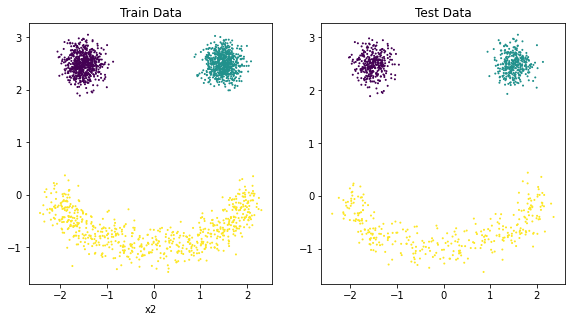

Dataset 2


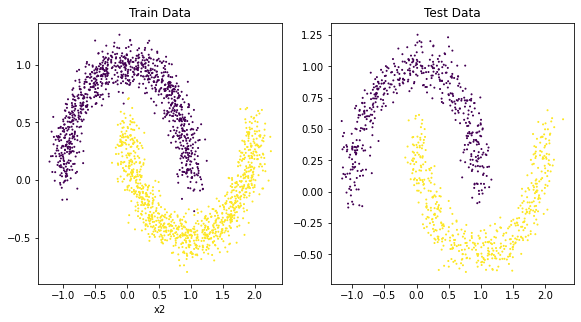

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
# from tqdm import tqdm

def train(model, data_loader, optimizer, device):
  # Returns list of train losses for each batch
  model.train()
  train_losses = []
  for x in data_loader:
    x = x.to(device)
    # x += torch.distributions.Uniform(0.0, 0.5).sample(x.shape).to(ptu.device)

    loss = model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

  return train_losses

def eval_model(model, data_loader, device):
  model.eval()

  test_loss = 0.0

  with torch.no_grad():
    for x in data_loader:
      x = x.to(device)
      # x += torch.distributions.Uniform(0.0, 0.5).sample(x.shape).to(ptu.device)

      loss = model.loss(x)

      test_loss = test_loss + loss*x.shape[0]
    test_loss = test_loss/len(data_loader.dataset)

  return test_loss.item()

    

def train_model(model, train_data_loader, test_data_loader, train_args):

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  # device = xm.xla_device()
  print("Using device ... ", device)
  model = model.to(device)
  epochs = train_args.get('epochs', 10)
  lr = train_args.get('lr', 1e-3)

  optimizer = optim.Adam(params = model.parameters(), lr = lr)

  train_losses = []
  test_losses = [eval_model(model, test_data_loader, device)]

  for i in range(0, epochs):
    model.train()

    train_losses.extend(train(model = model, data_loader = train_data_loader, optimizer = optimizer,
                            device = device))
    test_loss_epoch = eval_model(model = model, data_loader = test_data_loader, device = device)
    test_losses.append(test_loss_epoch)

    print("Epoch: ",(i+1)," Test Loss: ",test_loss_epoch)

  return train_losses, test_losses

## Part (a) Autoregressive Flow [15pt]

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d \log p(z_i) + \log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Show a heatmap of the densities learned by your model
4. Show what the training set looks like when mapped to the latent space. 




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MaskedLayer(nn.Module):
  def __init__(self, in_features, out_features, d, bias=True):
    super(MaskedLayer, self).__init__()

    self.in_features = in_features
    self.out_features = out_features
    self.d = d

    self.weights = nn.Linear(in_features = in_features, out_features = out_features, bias = bias)
    
    self.register_buffer(
            "mask", torch.ones_like(self.weights.weight).type(torch.uint8)
        )

    # Assign number between 1 - d-1 to each neuron
    c = 0
    while(c <= 10):
      c += 1
      self.mask_vals = torch.randint(low = 1, high = self.d, size = (out_features, ))
      all_vals = set(np.arange(1, self.d))
      if len(all_vals - set(self.mask_vals.numpy())) == 0:
        break


  def set_mask(self, prev_layer_mask):
    p_t = prev_layer_mask.unsqueeze(0).repeat((self.mask_vals.shape[0], 1))
    c_t = self.mask_vals.unsqueeze(0).T.repeat((1, prev_layer_mask.shape[0]))
    self.mask = (c_t >= p_t).int()


  def forward(self, x):  
    out = F.linear(input = x, weight = self.mask*self.weights.weight, bias = self.weights.bias)
    return out



class MADE(nn.Module):
  """
  Given input x_1,...x_N, output x_1,..x_N using autoregressive masks
  Input size: N
  Output size: N
  """

  def __init__(self, nin, hidden_sizes, n_mix):
    super(MADE, self).__init__()
    
    
    self.nin = nin
    self.hidden_sizes = hidden_sizes
    self.nout = nin*n_mix*3
    self.n_mix = n_mix
    

    inp_layer_mask = torch.arange(start = 1, end = nin + 1)
    inp_layer_mask[-1] = 1e9


    out_layer_mask = torch.arange(start = 0, end = nin)
    out_layer_mask = out_layer_mask.unsqueeze(0).T.repeat((1, n_mix*3)).view(self.nout)

    self.nn_list = []

    # hidden sizes excludes output layer

    prev_layer_mask = inp_layer_mask
    in_feats = nin
    for i in range(0, len(hidden_sizes)):
      
      layer = MaskedLayer(in_feats, hidden_sizes[i], nin)
      layer.set_mask(prev_layer_mask)
      
      self.nn_list.extend([layer, nn.ReLU()])

      prev_layer_mask = layer.mask_vals
      in_feats = hidden_sizes[i]
    
    output_layer = MaskedLayer(hidden_sizes[-1], self.nout, nin)
    output_layer.mask_vals = out_layer_mask
    output_layer.set_mask(prev_layer_mask)
    self.nn_list.extend([output_layer])

    self.net = nn.Sequential(*self.nn_list)


  def forward(self, x):
    # x -> batch_size x input_shape
    # print("Before: ",x.shape)
    batch_size = x.shape[0]

    x = x.float()
    x = x.view(batch_size, self.nin)

    out = self.net(x) # batch_size x n_in
    
    return out


class Flow_model(nn.Module):
  """
  Given x_1,..x_N , gets x_1,..x_N using MADE
  Maps x_1, ... x_N to z_1,...z_N using mixture of logistics
  Computes loss based on z_dist as Uniform ~ (0,1)
  """
  def __init__(self, nin, hidden_sizes, n_mix):
    super(Flow_model, self).__init__()
    
    self.nin = nin
    self.hidden_sizes = hidden_sizes
    self.n_mix = n_mix

    # MADE model to output x's based on autoregressive property
    self.made = MADE(nin = nin, hidden_sizes = hidden_sizes, n_mix = n_mix)

  def get_made_out(self, x):
    batch_size = x.shape[0]
    made_out = self.made(x) # batch_size x n_mix x 3 x nin
    
    made_out = made_out.view(batch_size, self.nin, 3, self.n_mix)  

    weights = made_out[:, :, 0, :] # batch_size x nin x n_mix
    means = made_out[:, :, 1, :] # batch_size x nin x n_mix
    log_scales = made_out[:, :, 2, :] # batch_size x nin x n_mix

    return weights, means, log_scales
    

  def forward(self, x):
    
    weights, means, log_scales = self.get_made_out(x)

    # Now get the flow
    z, _ = self.flow(x, weights, means, log_scales)
    return z

  def flow(self, x, weights, means, log_scales):
    out = x.unsqueeze(-1)
    
    # convert weights between 0 - 1
    softmax = nn.Softmax(dim = 2)
    logits = softmax(weights)

    # convert log_scales to scales
    scales = torch.exp(log_scales)

    # Using logistic distribution
    base_distribution = torch.distributions.Uniform(0, 1)
    transforms = [torch.distributions.SigmoidTransform().inv, torch.distributions.AffineTransform(loc=means, scale=scales)]
    dist = torch.distributions.TransformedDistribution(base_distribution, transforms)
    
    # print(dist.cdf(out).shape)
    z = torch.sum(dist.cdf(out)*logits, dim = 2)

    probs = torch.exp(dist.log_prob(out))
    log_det = torch.log(torch.sum(logits*probs, dim = 2))

    return z, log_det

    
  def loss(self, x):
    log_det = self.log_prob(x)

    return -torch.mean(log_det)


  def log_prob(self, x):
    
    weights, means, log_scales = self.get_made_out(x)

    # Now get the flow
    z, log_det = self.flow(x, weights, means, log_scales)

    return log_det.mean(dim=1)

    

  def get_latents(self, x):
    x_tensor = torch.Tensor(x)
    
    return self(x_tensor).cpu().detach().numpy()








In [ ]:
import deepul.pytorch_util as ptu
def q1_a(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """
  # create data loaders
  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 128, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 128)

  # model
  model = Flow_model(nin=2, hidden_sizes = [100, 100], n_mix = 5)

  # train
  train_args = {'epochs':100, 'lr':5e-3}
  train_losses, test_losses = train_model(model = model, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)
  
  

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
  densities = np.exp(ptu.get_numpy(model.log_prob(mesh_xs)))

  latents = model.get_latents(train_data)

  return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Using device ...  cpu
Epoch:  1  Test Loss:  1.6968088786285964
Epoch:  2  Test Loss:  1.465239212607012
Epoch:  3  Test Loss:  1.3339870675542669
Epoch:  4  Test Loss:  1.2635930983200099
Epoch:  5  Test Loss:  1.2126143516299552
Epoch:  6  Test Loss:  1.215932396031037
Epoch:  7  Test Loss:  1.2083057973036737
Epoch:  8  Test Loss:  1.2075115761637705
Epoch:  9  Test Loss:  1.1730704130822307
Epoch:  10  Test Loss:  1.1467402537659737
Epoch:  11  Test Loss:  1.1665315672337817
Epoch:  12  Test Loss:  1.1461646164317518
Epoch:  13  Test Loss:  1.114271376783538
Epoch:  14  Test Loss:  1.0799840407766954
Epoch:  15  Test Loss:  1.0078665485651028
Epoch:  16  Test Loss:  0.921696506746535
Epoch:  17  Test Loss:  0.8495177008476898
Epoch:  18  Test Loss:  0.7914426252827602
Epoch:  19  Test Loss:  0.7628808007013502
Epoch:  20  Test Loss:  0.7342525042925419
Epoch:  21  Test Loss:  0.7222081211011993
Epoch:  22  Test Loss:  0.7007798001215418
Epoch:  23  Test Loss:  0.6857918136308551
Ep

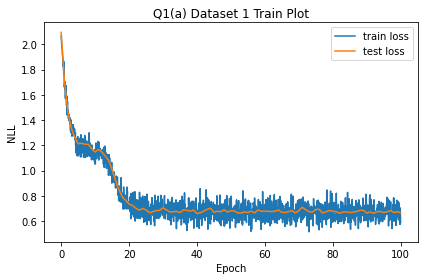

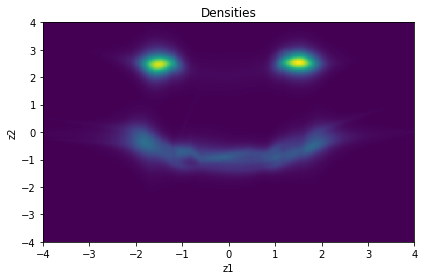

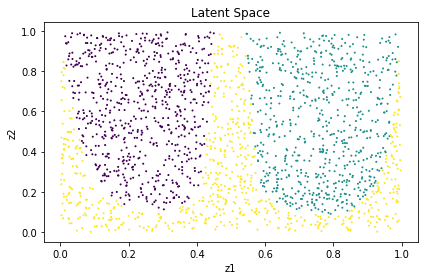

In [ ]:
q1_save_results(1, 'a', q1_a)

Using device ...  cpu
Epoch:  1  Test Loss:  1.0715482548509867
Epoch:  2  Test Loss:  0.9928768939141003
Epoch:  3  Test Loss:  0.834710848821019
Epoch:  4  Test Loss:  0.7667144636767442
Epoch:  5  Test Loss:  0.7131044329792087
Epoch:  6  Test Loss:  0.6944291278877575
Epoch:  7  Test Loss:  0.6914184148954157
Epoch:  8  Test Loss:  0.7288967313516023
Epoch:  9  Test Loss:  0.6886456304705553
Epoch:  10  Test Loss:  0.6867412248329781
Epoch:  11  Test Loss:  0.7522005694053874
Epoch:  12  Test Loss:  0.6737733385354837
Epoch:  13  Test Loss:  0.680434893213489
Epoch:  14  Test Loss:  0.6686641066532053
Epoch:  15  Test Loss:  0.6532586877321616
Epoch:  16  Test Loss:  0.6487946546565357
Epoch:  17  Test Loss:  0.6814330551446741
Epoch:  18  Test Loss:  0.663736503009109
Epoch:  19  Test Loss:  0.664451610362409
Epoch:  20  Test Loss:  0.6554721978285407
Epoch:  21  Test Loss:  0.6607267221376568
Epoch:  22  Test Loss:  0.6632351426188067
Epoch:  23  Test Loss:  0.7056090219548851
Ep

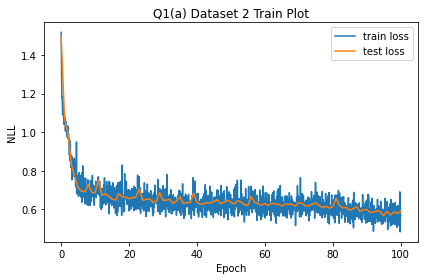

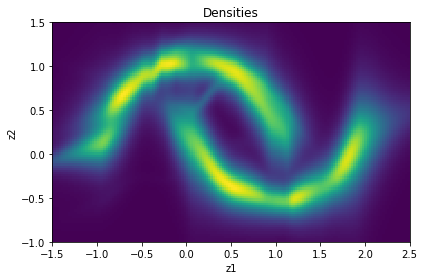

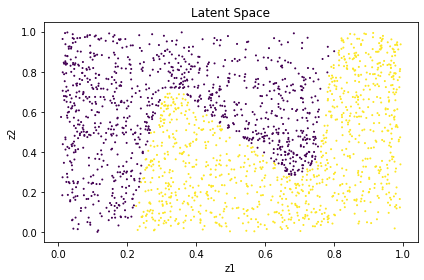

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) RealNVP [15pt]
In this part, we want to train a flow with the following structure: 
$(z_1, z_2) = (f_{\theta, 1} \circ \cdots \circ f_{\theta, n})$, 
where each $f_{\theta, i}$ is an affine transformation of 1 dimension, conditioned on the other, and $z \sim N(0, I)$. According to [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803) Section 4.1, there's a particularly good way to parameterize the affine transformation:

Assuming that we're conditioning on $x_1$ and transforming $x_2$, we have 

- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters.


**Train a RealNVP model and provide the same set of corresponding deliverables as part (a)**

In [ ]:
class Scale_Shift(nn.Module):
  def __init__(self, hidden_sizes, inp_dim = 1):
    super(Scale_Shift, self).__init__()
    models = []
    models.append(nn.Linear(inp_dim, hidden_sizes[0]))
    for i in range(1, len(hidden_sizes)):
      models.append(nn.Sigmoid())
      models.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
      
    models.append(nn.Sigmoid())
    models.append(nn.Linear(hidden_sizes[-1], inp_dim*2)) # output g_theta_scale & g_theta_shift
    
    self.net = nn.Sequential(*models)

  def forward(self, x):
    x = x.float()
    out = self.net(x)
    return out

# Define an affine layer
class AffineLayer(nn.Module):
  def __init__(self, hidden_sizes, switch_flg = 0, inp_dim = 2):

    super(AffineLayer, self).__init__()
    self.switch_flg = switch_flg
    

    self.dim_half = inp_dim//2
    
    self.scale_shift = Scale_Shift(hidden_sizes, inp_dim = self.dim_half) # get g_theta_scale & g_theta_shift
    # self.log_scale_model = nn.Linear(self.dim_half, self.dim_half, bias = True) # to get the log_scale output
    self.scale = nn.Parameter(torch.zeros(self.dim_half,), requires_grad = True)
    self.shift = nn.Parameter(torch.zeros(self.dim_half,), requires_grad = True)
  

  def flow(self, x):
    x = x.float()
    x1, x2 = torch.chunk(x, 2, dim = 1)

    if not self.switch_flg:
      z1 = x1
      z2, log_scale = self.get_z2(x1, x2)
    else:
      z1, log_scale = self.get_z2(x2, x1)
      z2 = x2

    return torch.cat((z1, z2), dim = 1), log_scale

  def forward(self, x):
    z, _ = self.flow(x)
    return z

  def get_z2(self, x_first, x_second):
    batch_size = x_first.shape[0]
    out = self.scale_shift(x_first) # batch_size x 2*inp_dim 
    out = out.contiguous().view(batch_size, self.dim_half, 2) # Split it into scale and shift

    scale_param = out[:, :, 0] # batch_size x self.dim_half
    shift_param = out[:, :, 1] # batch_size x self.dim_half

    relu = nn.ReLU()
    log_scale_out = (self.scale*torch.tanh(scale_param) + self.shift) # batch_size x self.dim_half

    z2 = torch.exp(log_scale_out)*x_second + shift_param # batch_size x self.dim_half

    return z2, log_scale_out


class NVP(nn.Module):
  def __init__(self, hidden_sizes, affine_layers, inp_dim = 2):

    super(NVP, self).__init__()
    self.inp_dim = inp_dim
    self.affine_layers = affine_layers

    self.models = nn.ModuleList()
    for i in range(0, affine_layers):
      self.models.append(AffineLayer(hidden_sizes, i%2))
    

  def forward(self, x):
    z, _ = self.flow(x) # batch_size x inp_dim
    return z

  
  def flow(self, x):
    z = x
    log_det = torch.zeros(x.shape[0], x.shape[1]//2)
    for i in range(0, self.affine_layers):
      z, log_scale = self.models[i].flow(z)
      log_det += log_scale

    return z, log_det

  def log_prob(self, x):
    x = x.float()
    z, log_det = self.flow(x)
    dist = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))
    z_dist = dist.log_prob(z.float())
    log_prob_val = torch.sum(z_dist, dim=1) + torch.sum(log_det, dim = 1)
    return log_prob_val

  def loss(self, x):
    log_prob_val = self.log_prob(x)
    return -torch.mean(log_prob_val)

  def get_latents(self, x):
    x_tensor = torch.Tensor(x)
    
    return self(x_tensor).cpu().detach().numpy()




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
import deepul.pytorch_util as ptu
def q1_b(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in R^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """
  # create data loaders
  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 128, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 128)

  # model
  model = NVP([64, 64], 6)

  # train
  train_args = {'epochs':250, 'lr':5e-3}
  train_losses, test_losses = train_model(model = model, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)
  
  

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
  densities = np.exp(ptu.get_numpy(model.log_prob(mesh_xs)))

  latents = model.get_latents(train_data)

  return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Using device ...  cpu
Epoch:  1  Test Loss:  3.6764729022979736
Epoch:  2  Test Loss:  3.6779186725616455
Epoch:  3  Test Loss:  3.6451685428619385
Epoch:  4  Test Loss:  3.6641361713409424
Epoch:  5  Test Loss:  3.6471104621887207
Epoch:  6  Test Loss:  3.647448778152466
Epoch:  7  Test Loss:  3.6632118225097656
Epoch:  8  Test Loss:  3.658550262451172
Epoch:  9  Test Loss:  3.6342060565948486
Epoch:  10  Test Loss:  3.6608264446258545
Epoch:  11  Test Loss:  3.628310441970825
Epoch:  12  Test Loss:  3.6304280757904053
Epoch:  13  Test Loss:  3.628499746322632
Epoch:  14  Test Loss:  3.6333608627319336
Epoch:  15  Test Loss:  3.6198525428771973
Epoch:  16  Test Loss:  3.5990195274353027
Epoch:  17  Test Loss:  3.5957798957824707
Epoch:  18  Test Loss:  3.5856504440307617
Epoch:  19  Test Loss:  3.5358738899230957
Epoch:  20  Test Loss:  3.500854969024658
Epoch:  21  Test Loss:  3.4430973529815674
Epoch:  22  Test Loss:  3.2970693111419678
Epoch:  23  Test Loss:  3.0482237339019775
Epo

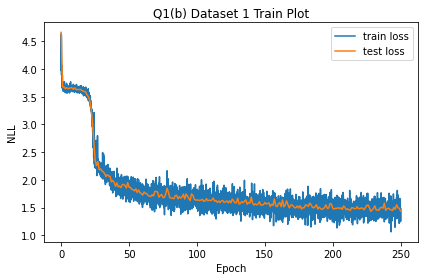

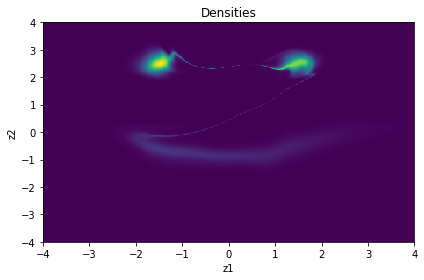

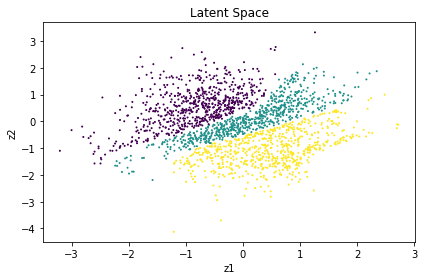

In [ ]:
q1_save_results(1, 'b', q1_b)

Using device ...  cpu
Epoch:  1  Test Loss:  2.058204174041748
Epoch:  2  Test Loss:  1.9493952989578247
Epoch:  3  Test Loss:  1.9350861310958862
Epoch:  4  Test Loss:  1.9229538440704346
Epoch:  5  Test Loss:  1.9680910110473633
Epoch:  6  Test Loss:  1.911583423614502
Epoch:  7  Test Loss:  1.93701171875
Epoch:  8  Test Loss:  1.943838357925415
Epoch:  9  Test Loss:  1.9095652103424072
Epoch:  10  Test Loss:  1.9343611001968384
Epoch:  11  Test Loss:  1.8968899250030518
Epoch:  12  Test Loss:  1.8967067003250122
Epoch:  13  Test Loss:  1.8853814601898193
Epoch:  14  Test Loss:  1.9040615558624268
Epoch:  15  Test Loss:  1.8901909589767456
Epoch:  16  Test Loss:  1.8476307392120361
Epoch:  17  Test Loss:  1.8473402261734009
Epoch:  18  Test Loss:  1.8287216424942017
Epoch:  19  Test Loss:  1.8318971395492554
Epoch:  20  Test Loss:  1.8265001773834229
Epoch:  21  Test Loss:  1.7978829145431519
Epoch:  22  Test Loss:  1.800726294517517
Epoch:  23  Test Loss:  1.7837095260620117
Epoch: 

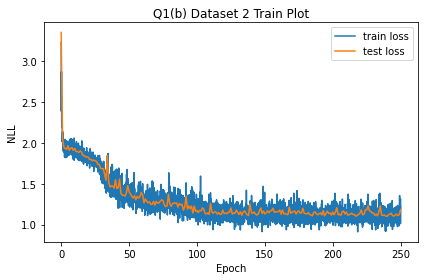

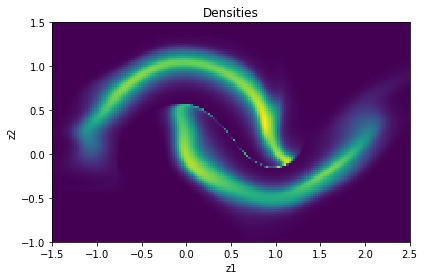

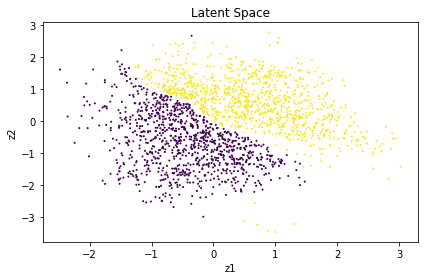

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2: Autoregressive Flows for Images [20pt]
We can scale up the autoregressive flows from 1(a) to high-dimensional image data. In this question, we will focus on the black-and-white shapes dataset from Homework 1.

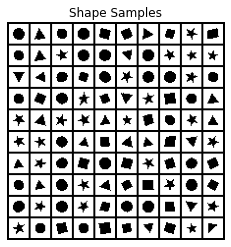

In [ ]:
visualize_q2_data()

Adapt your PixelCNN implementation from Homework 1 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 1 3(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
ptu.set_gpu_mode(True)
from torch.distributions.normal import Normal
class Binary_MaskedConvLayer(nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super(Binary_MaskedConvLayer, self).__init__(*args, **kwargs)

    assert mask_type == 'A' or mask_type == 'B'
    self.mask_type = mask_type
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask()
  
  def create_mask(self):
    k = self.kernel_size[0]

    # out_channels x in_channels x kernel_size x kernel_size
    self.mask[:, :, :k//2, :] = 1
    self.mask[:, :, k//2, :k//2] = 1

    if self.mask_type == 'B':
      self.mask[:, :, k//2, k//2] = 1


  def forward(self, x):
    out = F.conv2d(input = x, weight = self.weight * self.mask, bias = self.bias, stride = self.stride, 
                   padding = self.padding, dilation = self.dilation, groups = self.groups)
    return out

  
class Binary_PixelCNN(nn.Module):
  def __init__(self, n_mix, n_filters = 64):
    super(Binary_PixelCNN, self).__init__()

    self.n_filters = n_filters
    self.n_mix = n_mix
    models = []
    models.append(Binary_MaskedConvLayer(mask_type = 'A', in_channels = 1, out_channels = n_filters, kernel_size = 7, padding = 7//2))
    
    

    # 5 7 x 7 B conv layers
    for _ in range(0, 5):
      models.append(nn.BatchNorm2d(num_features = n_filters))
      models.append(nn.Sigmoid())
      models.append(Binary_MaskedConvLayer(mask_type = 'B', in_channels = n_filters, out_channels = n_filters, kernel_size = 7, padding = 7//2))
      
    
    # 2 1 x 1 B conv layers
    models.append(nn.BatchNorm2d(num_features = n_filters))
    models.append(nn.Sigmoid())
    models.append(Binary_MaskedConvLayer(mask_type = 'B', in_channels = n_filters, out_channels = n_filters, kernel_size = 1, padding = 1//2))
    models.append(nn.BatchNorm2d(num_features = n_filters))
    models.append(nn.Sigmoid())

    # output = 
    models.append(Binary_MaskedConvLayer(mask_type = 'B', in_channels = n_filters, out_channels = n_mix*3, kernel_size = 1, padding = 1//2))
    
    self.net = nn.Sequential(*models)

  def forward(self, x):
    out = self.net(x)
    return out

class PixelCNN_Flow(nn.Module):
  def __init__(self, n_mix):
    super(PixelCNN_Flow, self).__init__()
    self.n_mix = n_mix

    self.pixelcnn = Binary_PixelCNN(n_mix)


  def forward(self, x):

    x = x.float()
    # x += torch.distributions.Uniform(0.0, 0.5).sample(x.shape).to(ptu.device)
    
    batch_size = x.shape[0]

    inp_shape = (x.shape[1], x.shape[2], x.shape[3]) # 1 x W x H

    # samples = -1*torch.rand(*x.shape) + 0.5
    # x = (x.float() + samples.cuda())
    # x = (x + 0.5)/(2.0)

    out = self.pixelcnn(x)

    return out.view(batch_size, 3 * self.n_mix, *inp_shape)


  def loss(self, x):
    x = x.float()
    x += torch.distributions.Uniform(0.0, 0.5).sample(x.shape).to(ptu.device)
    out = self(x)

    batch_size = x.shape[0]

    inp_shape = (x.shape[1], x.shape[2], x.shape[3]) # 1 x W x H


    means, log_scales, weights = torch.chunk(out, 3, dim = 1) # batch_size, n_mix, inp_shape
    
    sm = nn.Softmax(dim = 1)
    logits = sm(weights)
    dist = Normal(means, log_scales.exp())
    log_det = dist.log_prob(x.unsqueeze(1))
    # print(log_det.min(), log_det.max())
    return -log_det.mean()
    

  def sample(self, n, input_shape):
    samples = torch.zeros(n, *input_shape).cuda()
    with torch.no_grad():
      for r in range(input_shape[1]):
        for c in range(input_shape[2]):
          for k in range(1):
            loc, log_scale, weight_logits = torch.chunk(self.forward(samples), 3, dim=1)
            loc, log_scale, weight_logits = loc[:,:,k,r,c], log_scale[:,:,k,r,c], weight_logits[:,:,k,r,c]
            probs = F.softmax(weight_logits, dim=1) # batch_size, n_mix, 1
            chosen_centers = torch.multinomial(probs, 1).squeeze(-1) # 1 x N
            samples[:, k, r, c] = torch.normal(loc[torch.arange(n), chosen_centers], log_scale[torch.arange(n), chosen_centers].exp())
    return samples.permute(0, 2, 3, 1).cpu().numpy()




In [ ]:
def q2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  """ YOUR CODE HERE """
  train_data = train_data.astype(np.float32)/2.0
  test_data = test_data.astype(np.float32)/2.0
  train_d = np.transpose(train_data, (0,3,1,2))
  test_d = np.transpose(test_data, (0,3,1,2))
  
  train_data_loader = data.DataLoader(dataset = train_d, batch_size = 128, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_d, batch_size = 128)

  # model
  model = PixelCNN_Flow(1)

  # train
  train_args = {'epochs':20, 'lr':1e-3}
  train_losses, test_losses = train_model(model = model, train_data_loader = train_data_loader, 
                                          test_data_loader = test_data_loader, train_args = train_args)
  samples = model.sample(100, (1, 20, 20))
  return train_losses + np.log(2), test_losses + np.log(2), samples
  

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



Using device ...  cuda
Epoch:  1  Test Loss:  -0.29601165652275085
Epoch:  2  Test Loss:  -0.3482823967933655
Epoch:  3  Test Loss:  -0.35170406103134155
Epoch:  4  Test Loss:  -0.37907761335372925
Epoch:  5  Test Loss:  -0.37830668687820435
Epoch:  6  Test Loss:  -0.40156325697898865
Epoch:  7  Test Loss:  -0.41427600383758545
Epoch:  8  Test Loss:  -0.42757248878479004
Epoch:  9  Test Loss:  -0.43091219663619995
Epoch:  10  Test Loss:  -0.42519083619117737
Epoch:  11  Test Loss:  -0.40970054268836975
Epoch:  12  Test Loss:  -0.4306306838989258
Epoch:  13  Test Loss:  -0.4399315118789673
Epoch:  14  Test Loss:  -0.4349196255207062
Epoch:  15  Test Loss:  -0.4096570312976837
Epoch:  16  Test Loss:  -0.448779433965683
Epoch:  17  Test Loss:  -0.45049771666526794
Epoch:  18  Test Loss:  -0.43923234939575195
Epoch:  19  Test Loss:  -0.43285635113716125
Epoch:  20  Test Loss:  -0.44983968138694763
Final Test Loss: 0.2433


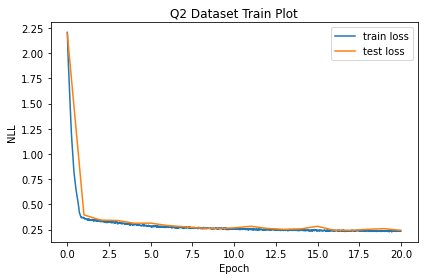

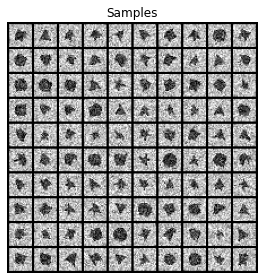

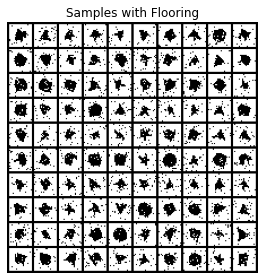

In [ ]:
q2_save_results(q2)

# Question 3: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



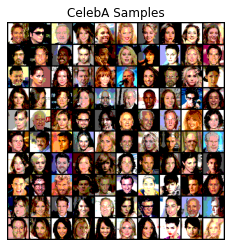

In [ ]:
visualize_q3_data()

## Part (a): RealNVP [40pt]

Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 128, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=n_filters, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=n_filters
  relu()
  conv2d(in_channels=n_filters, out_channels=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.55 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# Res-block
class ResnetBlock(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = n_filters, out_channels = n_filters, kernel_size = 1, padding = 0)
    self.conv2 = nn.Conv2d(in_channels = n_filters, out_channels = n_filters, kernel_size = 3, padding = 1)
    self.conv3 = nn.Conv2d(in_channels = n_filters, out_channels = n_filters, kernel_size = 1, padding = 0)

  def forward(self, x):
    out = self.conv1(x)
    out = F.relu(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.conv3(out)
    return out + x

# Net using resblocks
class SimpleResNet(nn.Module):
  def __init__(self, in_channels, out_channels, n_filters = 128, n_blocks = 8):
    super().__init__()
    models = []
    models.append(nn.Conv2d(in_channels = in_channels, out_channels = n_filters, kernel_size = 3, padding = 1))

    for _ in range(0, n_blocks):
      models.extend([nn.ReLU(), ResnetBlock(n_filters)])

    models.extend([nn.ReLU(), nn.Conv2d(in_channels = n_filters, out_channels = out_channels, kernel_size = 3, padding = 1)])

    self.net = nn.Sequential(*models)

  def forward(self, x):
    return self.net(x)

# Affine layer using checkerboard masking
class AffineCouplingCheckerboard(nn.Module):
  def __init__(self, input_size, switch_flg = False):
    super().__init__()

    
    C, H, W = input_size[0], input_size[1], input_size[2]

    # Gives out scale and shift params
    self.resnet = SimpleResNet(C, 2*C)
    self.switch_flg = switch_flg

    # Create mask
    self.register_buffer('mask', torch.arange(0, np.prod((H, W))))
    # self.mask = 
    self.mask = self.mask.view(1, H, W)
    self.mask = self.mask%2

    # if switch_flg is 0 then first value will be 1
    if not self.switch_flg:
      self.mask = 1 - self.mask
      
    
    self.mask = self.mask.unsqueeze(0)
    self.mask = self.mask.repeat(1, C, 1, 1)


  def forward(self, x):
    batch_size = x.shape[0]
    C, H, W = x.shape[1], x.shape[2], x.shape[3]

    mask_ = self.mask.repeat(batch_size, 1, 1, 1)
    
    x_ = x * mask_
    log_scale, t = torch.chunk(self.resnet(x_), 2, dim=1)

    z = x_ + (1 - mask_)*(x*torch.exp(log_scale) + t)
    
    log_det_jacobian = log_scale*(1 - mask_)
    return z, log_det_jacobian


  def reverse(self, z):
    batch_size = z.shape[0]
    C, H, W = z.shape[1], z.shape[2], z.shape[3]

    mask_ = self.mask.repeat(batch_size, 1, 1, 1)

    x_1 = z*mask_

    log_scale, t = torch.chunk(self.resnet(x_1), 2, dim = 1)
    x_2 = (z*(1 - mask_) - t*(1 - mask_))*torch.exp(-1*log_scale*(1 - mask_))

    x = x_1 + x_2

    return x


class AffineCouplingChannel(nn.Module):
  def __init__(self, input_size, switch_flg = False):
    super().__init__()

    C, H, W = input_size[0], input_size[1], input_size[2]

    self.resnet = SimpleResNet(C, 2*C)
    self.switch_flg = switch_flg

    # Create mask
    self.register_buffer('mask', torch.arange(0, C, ))
    # self.mask = 
    self.mask = self.mask.view(C, 1, 1)
    self.mask = self.mask//2

    # if switch_flg is 0 then first value will be 1
    if not self.switch_flg:
      self.mask = 1 - self.mask  
    
    self.mask = self.mask.unsqueeze(0)
    self.mask = self.mask.repeat(1, 1, H, W)


  def forward(self, x):
    batch_size = x.shape[0]
    C, H, W = x.shape[1], x.shape[2], x.shape[3]
    
    mask_ = self.mask.repeat(batch_size, 1, 1, 1)

    x_ = x * mask_
    log_scale, t = torch.chunk(self.resnet(x_), 2, dim=1)

    x_2 = (1 - mask_)
    z = x_ + (1 - mask_)*(x_2*torch.exp(log_scale) + t)
    
    log_det_jacobian = log_scale*(1 - mask_)
    return z, log_det_jacobian


  def reverse(self, z):
    batch_size = z.shape[0]
    C, H, W = z.shape[1], z.shape[2], z.shape[3]

    mask_ = self.mask.repeat(batch_size, 1, 1, 1)

    x_1 = z*mask_

    log_scale, t = torch.chunk(self.resnet(x_1), 2, dim = 1)
    x_2 = (z*(1 - mask_) - t*(1 - mask_))*torch.exp(-1*log_scale*(1 - mask_))

    x = x_1 + x_2

    return x


class RealNVP(nn.Module):
  def __init__(self, input_shape):
    super().__init__()

    C, H, W = input_shape[0], input_shape[1], input_shape[2]
    self.input_shape = input_shape

    self.z_dist = torch.distributions.Normal(0, 1)

    self.aff_1 = nn.ModuleList()

    for i in range(4):
      self.aff_1.append(AffineCouplingCheckerboard(input_shape, switch_flg = i%2))
      # self.aff_1.append(nn.BatchNorm2d(num_features = C))

    # self.aff_2 = nn.ModuleList()
    # for i in range(3):
    #   self.aff_2.append(AffineCouplingChannel((C*4, H//2, W//2), switch_flg = i%2))
    #   # self.aff_2.append(nn.BatchNorm2d(num_features = C*4))

    self.aff_3 = nn.ModuleList()
    for i in range(3):
      self.aff_3.append(AffineCouplingCheckerboard(input_shape, switch_flg = i%2))
      # self.aff_3.append(nn.BatchNorm2d(num_features = C))


  def squeeze(self, x):
    # x-> b x C x H x W
    batch_size, C, H, W = x.shape[0], x.shape[1], x.shape[2], x.shape[3]

    # out -> b x C*4 x H//2 x W//2
    x = torch.reshape(x, (batch_size, C, 2, H//2, 2, W//2))
    x = x.permute(0, 1, 4, 2, 3, 5)
    x = torch.reshape(x, (batch_size, C*4, H//2, W//2))

    return x

  def unsqueeze(self, x):
    batch_size, C, H, W = x.shape[0], x.shape[1], x.shape[2], x.shape[3]

    # out -> b x C*4 x H*2 x W*2
    x = torch.reshape(x, (batch_size, C//4, 2, 2, H, W))
    x = x.permute(0, 1, 3, 4, 2, 5)
    x = torch.reshape(x, (batch_size, C//4, 2*H, 2*W))
    return x


  def forward(self, x):
    out = x
    log_det_jacobian = torch.zeros_like(x)

    for l in self.aff_1:
      out, log_det = l(out)
      log_det_jacobian += log_det

    out = self.squeeze(out)
    log_det_jacobian = self.squeeze(log_det_jacobian)

    # for l in self.aff_2:
    #   out, log_det = l(out)
    #   log_det_jacobian += log_det
    # print(out)
    out = self.unsqueeze(out)
    log_det_jacobian = self.unsqueeze(log_det_jacobian)

    for l in self.aff_3:
      out, log_det = l(out)
      log_det_jacobian += log_det

    return out, log_det_jacobian

  def reverse(self, z):
    out = z.clone()

    for l in reversed(self.aff_3):
      out = l.reverse(out)

    out = self.squeeze(out)

    # for l in reversed(self.aff_2):
    #   out = l.reverse(out)

    out = self.unsqueeze(out)
    
    for l in self.aff_1:
      out = l.reverse(out)

    return out


  def log_prob(self, x):
    out, log_det_jacobian = self(x)
    z_prob = self.z_dist.log_prob(out)
    
    return (torch.sum(z_prob, [1,2,3]) + torch.sum(log_det_jacobian, [1,2,3]))

  def loss(self, x):
    return -1*((self.log_prob(x))/(np.prod(self.input_shape))).mean()

  def sample(self, N):
    z = self.z_dist.sample(torch.Size([N, *self.input_shape]))
    return self.reverse(z)

  



In [ ]:
import pytorch_lightning as pl
class NVP_trainer(pl.LightningModule):

  def __init__(self, input_shape, learning_rate = 5e-4, dequantize = 0, logit_trick = 1):
    super().__init__()
    self.model = RealNVP(input_shape = input_shape)
    # self.model = self.model.cuda()
    self.learning_rate = learning_rate
    self.dequantize = dequantize
    self.logit_trick = logit_trick
    self.train_loss_list = []
    self.val_loss_list = []
  
  def forward(self, x):
    return self.model.forward(x)

  def reverse(self, x):
    x = self.model.reverse(x)
    x = self.postprocess(x)
    return x.permute(0, 2, 3, 1).detach().numpy()  

  def sample(self, N):
    x = self.model.sample(N)
    x = self.postprocess(x)
    return x.permute(0, 2, 3, 1).detach().numpy()
  
  def loss(self, x):
    return self.model.loss(x)

  def configure_optimizers(self):
    return torch.optim.Adam(self.model.parameters(), lr = self.learning_rate)

  def training_step(self, batch, batch_idx):
    # batch = batch.cuda()
    x, log_det = self.preprocess(batch)
    loss_ = self.loss(x)
    # print(loss_.item())
    loss_ = loss_ + log_det
    # self.train_loss_list.append(loss_.item())
    pbar = {'train_loss': loss_}
    return {'loss': loss_, 'progress_bar': pbar}

  def validation_step(self, batch, batch_idx):
    # batch = batch.cuda()
    x, log_det = self.preprocess(batch)
    loss_ = self.loss(x)
    # print(loss_)
    loss_ = loss_ + log_det
    pbar = {'val_loss': loss_}
    return {'loss': loss_, 'progress_bar': pbar}

  # def validation_epoch_end(self, val_step_outs):
  #   # print(val_step_outs)
  #   val_loss_mean = torch.Tensor([x['progress_bar']['val_loss'] for x in val_step_outs]).mean()
  #   self.val_loss_list.append(val_loss_mean)
  #   return {'val_loss':val_loss_mean}

  def preprocess(self, x):
    log_det = torch.zeros_like(x).float()
    # dequantize 
    if self.dequantize:
      # TODO
      raise "Not Implemented Error"
    
    # Apply logit trick
    if self.logit_trick:
      x_s = x.float()/4.0
      alpha = 0.05
      x_t = alpha + (1 - alpha)*x_s
      x_out = torch.log(x_t) - torch.log1p(-x_t)
      log_det += (-1)*(torch.log(x_t) + torch.log(4.0 - x_s))
      x = x_out

    return x, log_det

  def postprocess(self, x):
    if self.logit_trick:
      alpha = 0.05
      x_t = torch.sigmoid(x)
      x_s = (x_t - alpha)/(1.0 - alpha)
      x = x_s*4.0

    return x



In [ ]:
from pytorch_lightning import Trainer
# torch.cuda.set_device(6)


def q3_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  C, H, W = train_data.shape[1], train_data.shape[2], train_data.shape[3]

  train_data_loader = data.DataLoader(dataset = train_data, batch_size = 16, shuffle = True)
  test_data_loader = data.DataLoader(dataset = test_data, batch_size = 16)  

  nvp_trainer = NVP_trainer((C, H, W), )
  trainer = Trainer(max_epochs=10)
  trainer.fit(nvp_trainer, train_data_loader, test_data_loader)

  samples = nvp_trainer.sample(100)

  return nvp_trainer.train_loss_list, nvp_trainer.val_loss_list, samples, samples[0:30]

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



In [ ]:
q3_save_results(q3_a, 'a')

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

  | Name  | Type    | Params
----------------------------------
0 | model | RealNVP | 10 M  


RuntimeError: ignored

## Part (b): Exploring bad masking schemes [10pt]

As shown in lecture, the choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

In [ ]:
def q3_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

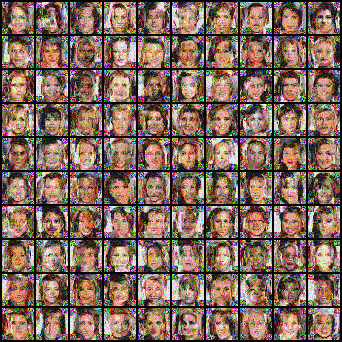

In [ ]:
q3_save_results(q3_b, 'b')

# Question 4: Bonus Questions (Optional)

## Q4(a): Multiscale RealNVP [10pt]
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def q4_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q4_a, 'bonus_a')

## Q4(b): Glow [5pt]
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def q4_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q4_b, 'bonus_b')

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)